In [2]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
from axon_data import brain2paths, brain2centers
import os
from util import json_to_points
import scipy.ndimage as ndi
import random
from cloudvolume import CloudVolume
%gui qt5

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject
/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Intensity Histograms

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


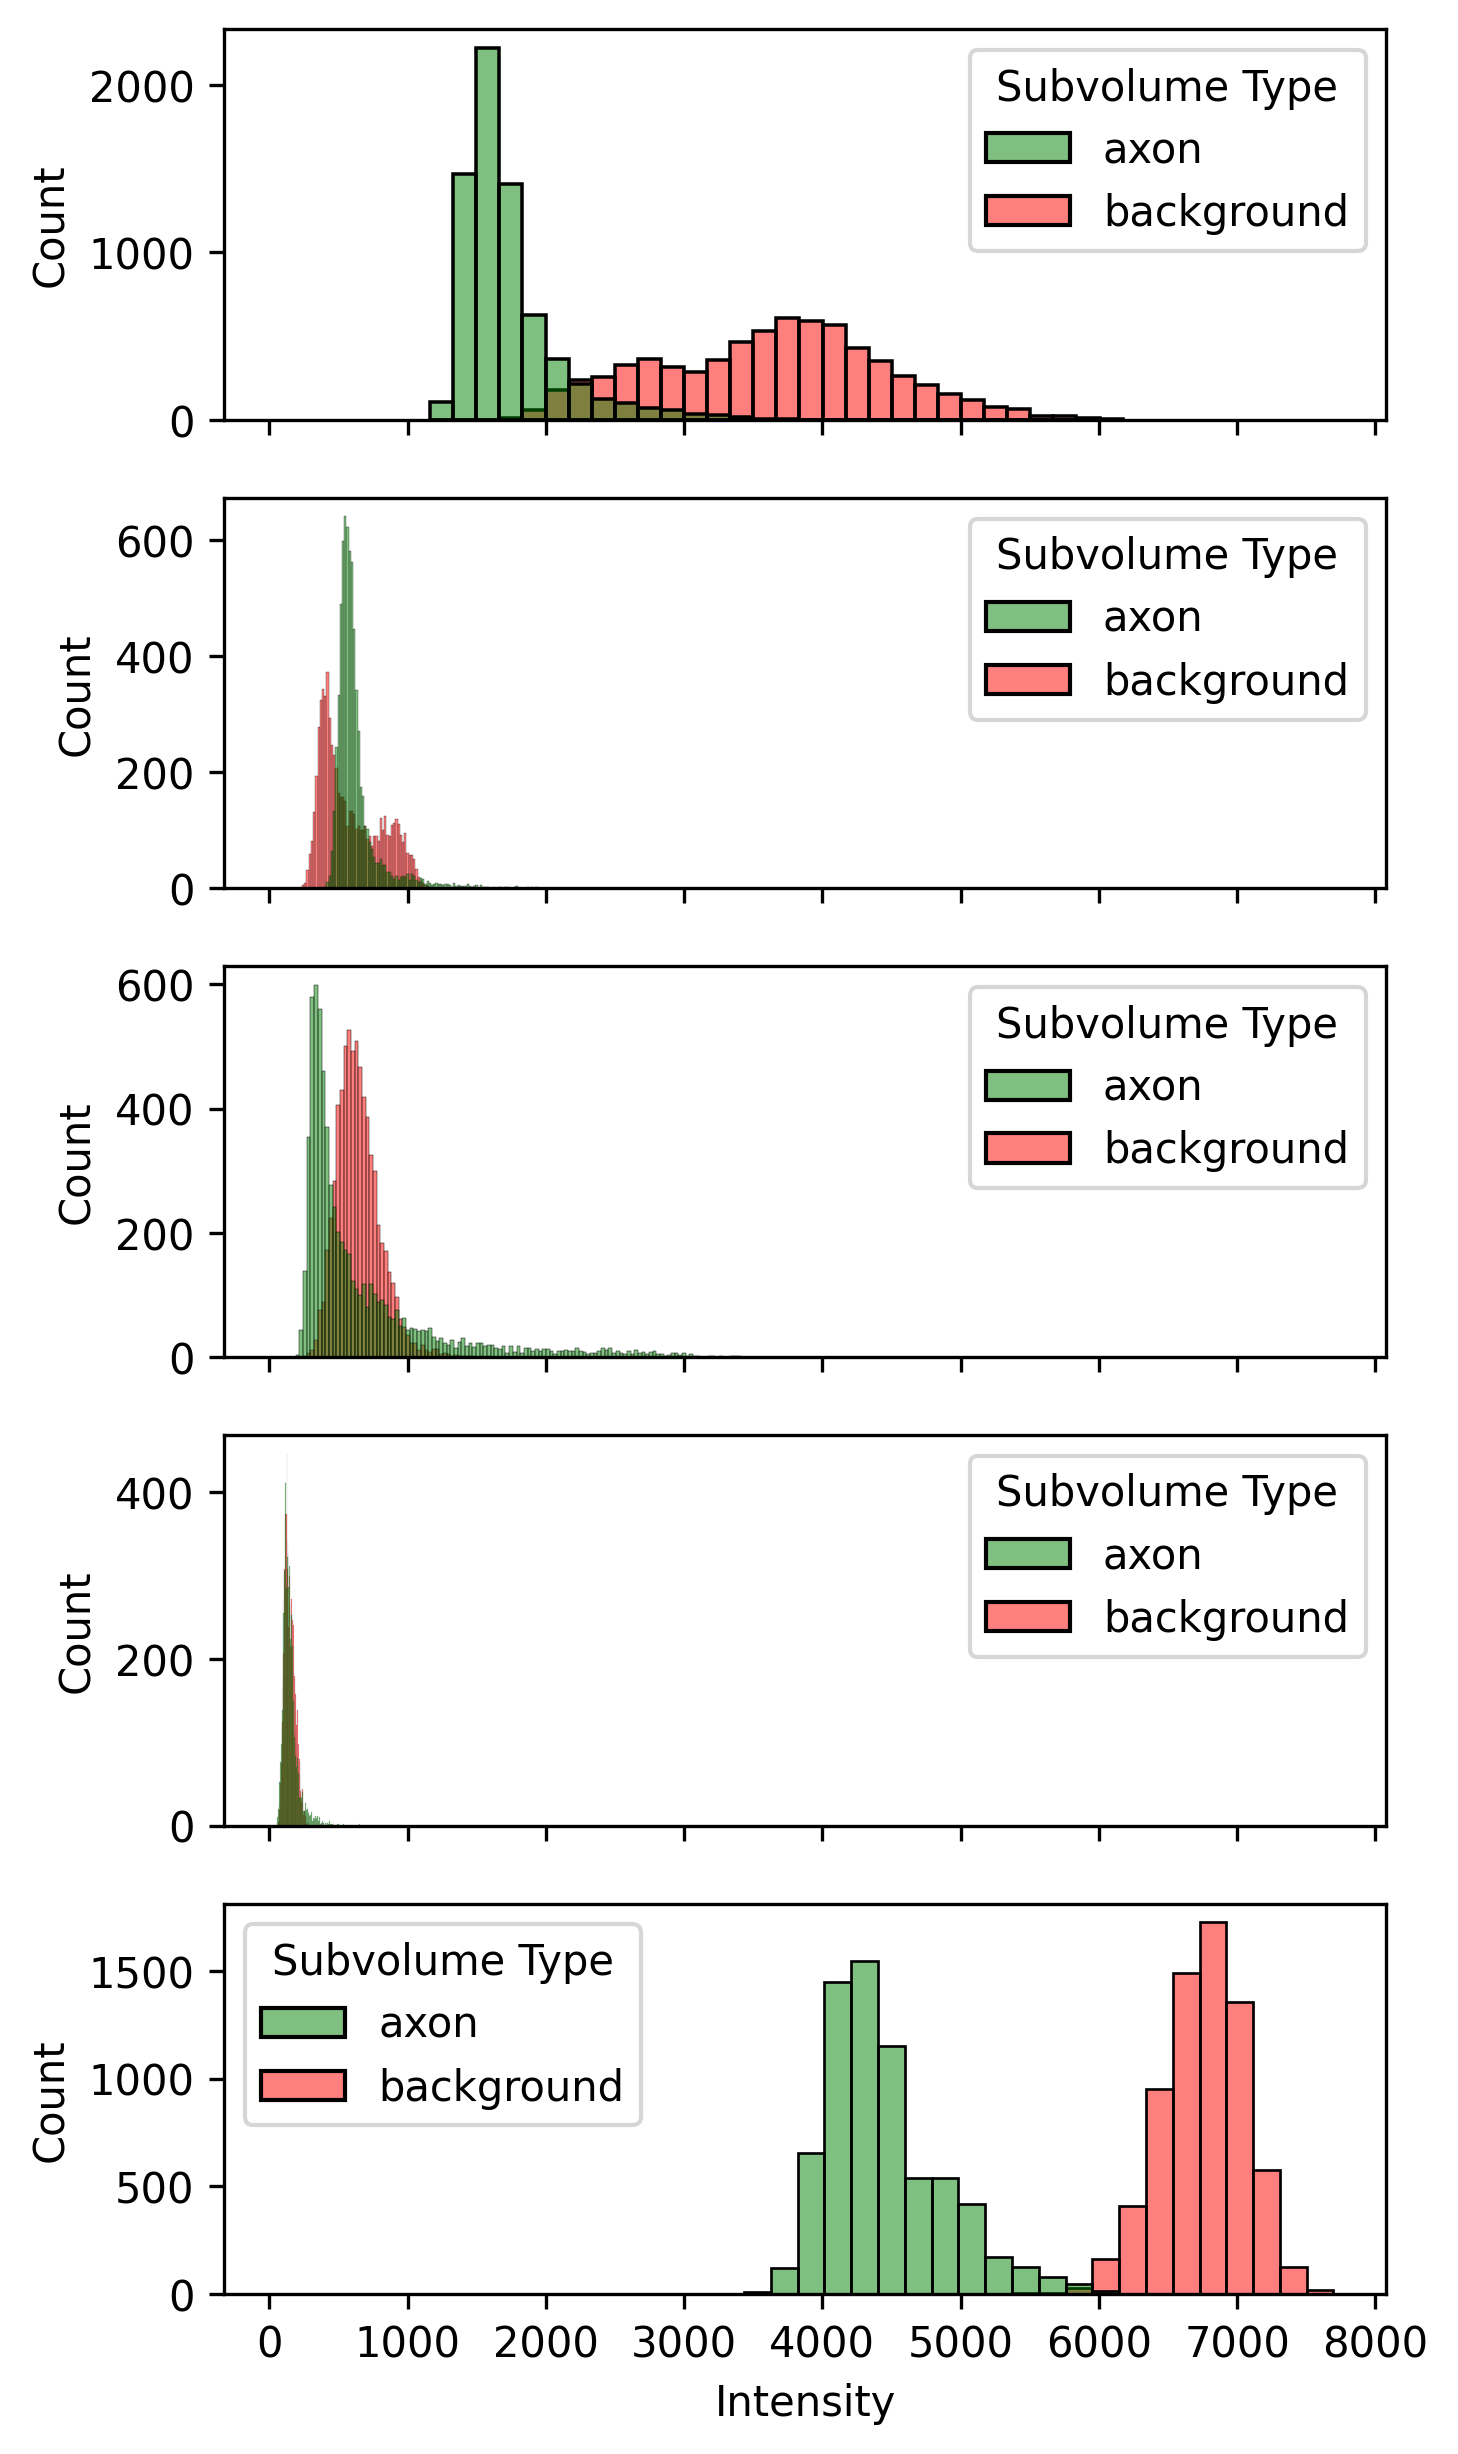

In [8]:
data = {"8649": ([2192, 1244, 1332], [901, 2559, 1332]),"8650": ([2378, 948, 1851], [2302, 5705, 1851]),"8589": ([4312, 4163, 1450], [1335, 6119, 1450]),"8613": ([3911, 3461, 1514], [1411, 5720, 1514]),"8590": ([1394, 1940, 1854], [4776, 816, 1854])} #axon center then nonaxon center

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(5,10), dpi=300)

for i, brain in enumerate(data.keys()):
    vol = CloudVolume(brain2paths[brain]["ab"])
    coord = data[brain][0]
    subvol = vol[coord[0]-9:coord[0]+10, coord[1]-9:coord[1]+10, coord[2]-9:coord[2]+10]
    intensities1 = list(subvol.flatten())
    subvol_types1 = ["axon"] * len(intensities1)


    coord = data[brain][1]
    subvol = vol[coord[0]-9:coord[0]+10, coord[1]-9:coord[1]+10, coord[2]-9:coord[2]+10]
    intensities2 = list(subvol.flatten())
    subvol_types2 = ["background"] * len(intensities2)

    intensities = intensities1 + intensities2
    subvol_types = subvol_types1 + subvol_types2

    df = pd.DataFrame(data = {"Intensity": intensities, "Subvolume Type": subvol_types})

    sns.histplot(data=df, x="Intensity", hue="Subvolume Type", ax=axes[i], palette=['green', 'red']) 

## Accuracy Plots

In [24]:
brain_order = [8649, 8650, 8589, 8613, 8590]
training_ids = {8589: [2, 6, 0, 9, 1], 8590: [13, 8, 3, 6, 10, 11, 0], 8613: [7, 0, 1, 6, 3],
    8649: ["train_722_2750_994", "val_3524_3585_955", "val_3300_3732_1284", "val_1341_1785_2028", "val_2872_2728_1284", "val_1251_2720_238", "val_2185_1315_1286", "train_1068_2796_301", "val_2358_4700_1276", "val_3381_2398_1294", "val_1349_4348_2027", "val_964_2196_782", "train_2230_1287_946", "val_1769_4238_607", "val_1555_2142_596", "train_2569_2776_142", "val_2879_1610_817"],
    8650: [7, 9, 5, 4, 1]}

## Tools

### Randomly choose training set

In [ ]:
base_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/brain8650/"
files = os.listdir(base_dir)
files = [base_dir + f for f in files if ".h5" in f]
l = len(files)
l_train = int(np.ceil(l/2))
random.shuffle(files)
print(files[:l_train])

### Convert labels

In [ ]:
base_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/brain8650/labels/"
files = os.listdir(base_dir)
files = [base_dir + f for f in files if "_Labels" in f]
files = [f for f in files if ".h5" in f]

for file in files:
    with h5py.File(file) as hf:
        labels = np.array(hf['exported_data'])
    io.imsave(file[:-3] + '.tif', labels)

### Move files 

In [ ]:
brain = "8650"
model = "brain3"

base_dir = (
            "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/val/brain"
            + brain
            + "/"
        )

files = os.listdir(base_dir)
files = [f for f in files if "_Probabilities" in f]

move = input(f"Rename {files} to {base_dir}{model}? (y/n)")
if move == "y":
    for file in files:
        os.rename(base_dir + file, f"{base_dir}{model}/{file}")

## Forward Learning Efficiency

In [49]:
lFLEs = []
tasks = np.arange(1, len(brain_order)+1)

for brain in tqdm(brain_order, desc="Evaluating brains..."):
    brain_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/brain{brain}/"
    trains = training_ids[brain]

    files = os.listdir(brain_dir)
    files = [f for f in files if ".h5" in f]

    val_files = []
    if isinstance(trains[0], str):
        for file in files:
            add = True
            for train in trains:
                if train in file:
                    add = False
                    break
            
            if add:
                val_files.append(file)
    elif isinstance(trains[0], int):
        for file in files:
            file_num = file.split("_")[1]
            file_num = int(file_num.split(".")[0])

            if file_num not in trains:
                val_files.append(file)
    else:
        raise ValueError("Training id's are neither strnigs or ints")


    forward_model = f"results"
    for i, fwd_brain in enumerate(brain_order):
        if i > 0:
            forward_model += "-"
        forward_model += f"{fwd_brain}"

        if fwd_brain == brain:
            break

    true_files = []
    baseline_files = []
    forward_files = []
    for val_file in val_files:
        true_file = f"{brain_dir}labels/{val_file.split('.')[0]}-image_2channel_Labels.h5"
        true_files.append(true_file)
        baseline_file = f"{brain_dir}results{brain}/{val_file.split('.')[0]}_Probabilities.h5"
        baseline_files.append(baseline_file)
        forward_file = f"{brain_dir}{forward_model}/{val_file.split('.')[0]}_Probabilities.h5"
        forward_files.append(forward_file)


    # Baseline
    spacing = 0.02
    thresholds = np.arange(spacing, 1.0, spacing)
    best_fscore_base = 0
    best_fscore_fwd = 0
    
    for threshold in tqdm(thresholds, desc="searching threshold...", leave=False):
        true_pos_total_base = 0
        true_pos_total_fwd = 0
        false_pos_total_base = 0
        false_pos_total_fwd = 0
        true_labels_total = 0

        for true_file, baseline_file, forward_file in zip(true_files, baseline_files, forward_files):
            f = h5py.File(baseline_file, "r")
            seg = f.get("exported_data")
            seg = seg[1, :, :, :]
            mask_base = seg > threshold

            f = h5py.File(forward_file, "r")
            seg = f.get("exported_data")
            seg = seg[1, :, :, :]
            mask_forward = seg > threshold

            f = h5py.File(true_file, "r")
            gt = f.get("exported_data")
            gt = gt[0, :, :, :]
            pos_labels = gt == 2
            neg_labels = gt == 1

            true_pos = np.sum(np.logical_and(mask_base, pos_labels))
            true_pos_total_base += true_pos
            true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
            true_pos_total_fwd += true_pos

            false_pos = np.sum(np.logical_and(mask_base, gt == 1))
            false_pos_total_base += false_pos
            false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
            false_pos_total_fwd += false_pos

            true_labels = np.sum(pos_labels)
            true_labels_total += true_labels


        precision_total_base = true_pos_total_base / (true_pos_total_base + false_pos_total_base)
        recall_total_base = true_pos_total_base / true_labels_total
        fscore_base = 2 / (1 / precision_total_base + 1 / recall_total_base)

        precision_total_fwd = true_pos_total_fwd / (true_pos_total_fwd + false_pos_total_fwd)
        recall_total_fwd = true_pos_total_fwd / true_labels_total
        fscore_fwd = 2 / (1 / precision_total_fwd + 1 / recall_total_fwd)

        if fscore_base > best_fscore_base:
            best_fscore_base = fscore_base
        if fscore_fwd > best_fscore_fwd:
            best_fscore_fwd = fscore_fwd
    lFLEs.append(np.log((1-best_fscore_base)/(1-best_fscore_fwd)))
        



Evaluating brains...: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]


(
    [
        <matplotlib.axis.XTick object at 0x15b4499d0>,
        <matplotlib.axis.XTick object at 0x15b449ee0>,
        <matplotlib.axis.XTick object at 0x15b44d3d0>,
        <matplotlib.axis.XTick object at 0x15b47c580>,
        <matplotlib.axis.XTick object at 0x15b4838e0>
    ],
    [
        Text(1, 0, '1'),
        Text(2, 0, '2'),
        Text(3, 0, '3'),
        Text(4, 0, '4'),
        Text(5, 0, '5')
    ]
)

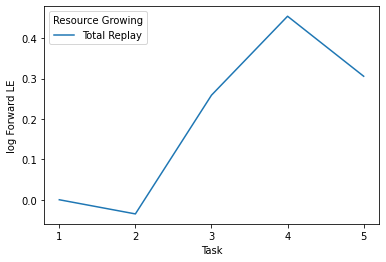

In [50]:
methods = ["Total Replay" for t in tasks]
data = {"Task": tasks, "log Forward LE": lFLEs, "Resource Growing": methods}
df = pd.DataFrame(data=data)
sns.lineplot(data=df, x="Task", y="log Forward LE", hue = "Resource Growing")
plt.xticks(tasks, tasks)

## Backward Learning Efficiency

In [62]:
lBLEs = []
tasks = []
dsets = []

for brain1_id, brain1 in enumerate(tqdm(brain_order, desc="Evaluating brains...")):
    brain_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/brain{brain1}/"
    trains = training_ids[brain1]

    files = os.listdir(brain_dir)
    files = [f for f in files if ".h5" in f]

    val_files = []
    if isinstance(trains[0], str):
        for file in files:
            add = True
            for train in trains:
                if train in file:
                    add = False
                    break
            
            if add:
                val_files.append(file)
    elif isinstance(trains[0], int):
        for file in files:
            file_num = file.split("_")[1]
            file_num = int(file_num.split(".")[0])

            if file_num not in trains:
                val_files.append(file)
    else:
        raise ValueError("Training id's are neither strnigs or ints")

    # Intermediate datasets
    for brain2_id, brain2 in enumerate(tqdm(brain_order[brain1_id:], desc="Iterating through intermediate datasets...", leave=False)):
        backward_model = f"results"
        for i, fwd_brain in enumerate(brain_order[:brain2_id+brain1_id+1]):
            if i > 0:
                backward_model += "-"
            backward_model += f"{fwd_brain}"

            if fwd_brain == brain:
                break

        true_files = []
        backward_files = []
        for val_file in val_files:
            true_file = f"{brain_dir}labels/{val_file.split('.')[0]}-image_2channel_Labels.h5"
            true_files.append(true_file)
            backward_file = f"{brain_dir}{backward_model}/{val_file.split('.')[0]}_Probabilities.h5"
            backward_files.append(backward_file)


        # Baseline
        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore_back = 0
        
        for threshold in tqdm(thresholds, desc="searching threshold...", leave=False):
            true_pos_total_back = 0
            false_pos_total_back = 0
            true_labels_total = 0

            for true_file, backward_file in zip(true_files, backward_files):
                f = h5py.File(backward_file, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask_back = seg > threshold

                f = h5py.File(true_file, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask_back, pos_labels))
                true_pos_total_back += true_pos

                false_pos = np.sum(np.logical_and(mask_back, gt == 1))
                false_pos_total_back += false_pos

                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels


            precision_total_back = true_pos_total_back / (true_pos_total_back + false_pos_total_back)
            recall_total_back = true_pos_total_back / true_labels_total
            fscore_back = 2 / (1 / precision_total_back + 1 / recall_total_back)

            if fscore_back > 1:
                raise ValueError(f"Invalid f score: base {precision_total_back}, {recall_total_back} -> {fscore_back}")

            if fscore_back > best_fscore_back:
                best_fscore_back = fscore_back
        if brain2 == brain1:
            best_fscore_base = best_fscore_back


        tasks.append(brain1_id)
        dsets.append(brain2_id+brain1_id)  
        lBLEs.append(np.log((1-best_fscore_base)/(1-best_fscore_back)))
        



Evaluating brains...:   0%|          | 0/5 [00:00<?, ?it/s]






























































































































































































































































Evaluating brains...:  20%|██        | 1/5 [00:35<02:21, 35.28s/it]







































































Evaluating brains...:  40%|████      | 2/5 [00:43<00:57, 19.32s/it]






















































Evaluating brains...:  60%|██████    | 3/5 [00:50<00:26, 13.50s/it]




































Evaluating brains...:  80%|████████  | 4/5 [00:54<00:09,  9.95s/it]


























Evaluating brains...: 100%|██████████| 5/5 [00:57<00:00, 11.51s/it]


(
    [
        <matplotlib.axis.XTick object at 0x15b82f850>,
        <matplotlib.axis.XTick object at 0x15b82f820>,
        <matplotlib.axis.XTick object at 0x15b8207c0>,
        <matplotlib.axis.XTick object at 0x15b863cd0>,
        <matplotlib.axis.XTick object at 0x15b8746a0>,
        <matplotlib.axis.XTick object at 0x15b874df0>,
        <matplotlib.axis.XTick object at 0x15b87d580>,
        <matplotlib.axis.XTick object at 0x15b874c10>,
        <matplotlib.axis.XTick object at 0x15b863520>,
        <matplotlib.axis.XTick object at 0x15b87ddf0>,
        <matplotlib.axis.XTick object at 0x15b883580>,
        <matplotlib.axis.XTick object at 0x15b8286a0>,
        <matplotlib.axis.XTick object at 0x15b897df0>,
        <matplotlib.axis.XTick object at 0x15b8b1580>,
        <matplotlib.axis.XTick object at 0x15b8b1cd0>
    ],
    [
        Text(0, 0, '0'),
        Text(0, 0, '0'),
        Text(0, 0, '0'),
        Text(0, 0, '0'),
        Text(0, 0, '0'),
        Text(1, 0, '1'),
        Text(1, 0, '1'),
        Text(1, 0, '1'),
        Text(1, 0, '1'),
        Text(2, 0, '2'),
        Text(2, 0, '2'),
        Text(2, 0, '2'),
        Text(3, 0, '3'),
        Text(3, 0, '3'),
        Text(4, 0, '4')
    ]
)

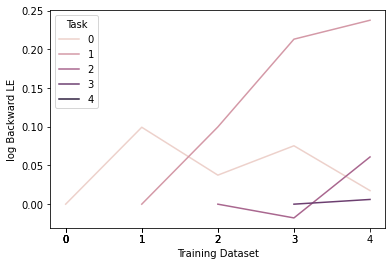

In [64]:
methods = ["Total Replay" for t in tasks]
data = {"Task": tasks, "log Backward LE": lBLEs, "Training Dataset": dsets}
df = pd.DataFrame(data=data)
sns.lineplot(data=df, x="Training Dataset", y="log Backward LE", hue="Task")
plt.xticks(tasks, tasks)

## Verify Training

In [55]:
f = h5py.File("/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/test/val_2_Probabilities_full.h5", "r")
seg = f.get("exported_data")
seg_full = seg[1, :, :, :]

f = h5py.File("/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/paper-brains/test/val_2_Probabilities.h5", "r")
seg = f.get("exported_data")
seg_seq = seg[1, :, :, :]

In [56]:
seg_full

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [57]:
seg_seq

array([[[0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]],

       [[0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]],

       ...,

       [[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]],

       [[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]],

       [[0.01, 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
        [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]]], dtype=float32)

## PR Curves

In [ ]:
brains = ["8650", "8649", 
    "8613", "8589", "8590"]

model_names = ["brain8649", "brain8649-3", "brain3-4-8649"] #["brain3", "brain3-4", "brain3-4-8649"]

brain_ids = []
precisions = []
recalls = []
models = []

best_precisions = []
best_recalls = []
best_fscores = {}

for model in model_names: 
    for brain in brains:

        base_dir = (
            "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/val/brain"
            + brain
            + "/"
        )

        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore = 0

        files = os.listdir(base_dir)
        files = [f for f in files if "val" in f]
        files = [f for f in files if "_Labels.h5" not in f]
        files = [f for f in files if "_Probabilities.h5" not in f]

        print(f"{len(files)} total validation subvolumes for brain {brain}")

        for threshold in thresholds:
            true_pos_total = 0
            false_pos_total = 0
            true_labels_total = 0
            true_labels_total_neg = 0
            for fname in files:
                fname_im = base_dir + fname
                f = h5py.File(fname_im, "r")
                im = f.get("image_2channel")
                im_bg = im[0, :, :, :]
                im_fg = im[1, :, :, :]

                fname_prob = f"{base_dir}{model}/{fname[:-3]}_Probabilities.h5"
                f = h5py.File(fname_prob, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask = seg > threshold

                fname_lab = f"{base_dir}labels/{fname[:-3]}-image_2channel_Labels.h5" 
                f = h5py.File(fname_lab, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask, pos_labels))
                true_pos_total += true_pos
                false_pos = np.sum(np.logical_and(mask, gt == 1))
                false_pos_total += false_pos
                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels
                true_labels_neg = np.sum(neg_labels)
                true_labels_total_neg += true_labels_neg

            precision_total = true_pos_total / (true_pos_total + false_pos_total)
            recall_total = true_pos_total / true_labels_total

            precisions.append(precision_total)
            recalls.append(recall_total)
            brain_ids.append(brain)
            models.append(model)

            fscore = 2 / (1 / precision_total + 1 / recall_total)

            if fscore > best_fscore:
                best_fscore = fscore
                best_prec = precision_total
                best_recall = recall_total
                best_threshold = threshold
        best_precisions.append(best_prec)
        best_recalls.append(best_recall)
        best_fscores[brain] = best_fscore

for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores[brain_id]:.2f}"

data = {"Sample": brain_ids, "Recall": recalls, "Precision": precisions, "Model": models}
df = pd.DataFrame(data=data)


sns.set(rc={"figure.figsize": (10, 7)})
sns.set(font_scale=2)
sns.lineplot(data=df, x="Recall", y="Precision", hue="Sample", style="Model")
sns.scatterplot(x=best_recalls, y=best_precisions)

## Change of max f score

In [ ]:
brains = ["8650", "8649", 
    "8613", "8589", "8590"]

model_names = ["brain3", "brain3-4", "brain3-4-8649"]

brain_ids = []
best_fscores = []
models = []

best_precisions = []
best_recalls = []
best_fscores_dict = {}

for model in model_names: 
    for brain in brains:

        base_dir = (
            "/Users/thomasathey/Documents/mimlab/mouselight/ailey/continual-learning/val/brain"
            + brain
            + "/"
        )

        spacing = 0.02
        thresholds = np.arange(spacing, 1.0, spacing)
        best_fscore = 0

        files = os.listdir(base_dir)
        files = [f for f in files if "val" in f]
        files = [f for f in files if "_Labels.h5" not in f]
        files = [f for f in files if "_Probabilities.h5" not in f]

        print(f"{len(files)} total validation subvolumes for brain {brain}")

        for threshold in thresholds:
            true_pos_total = 0
            false_pos_total = 0
            true_labels_total = 0
            true_labels_total_neg = 0
            for fname in files:
                fname_im = base_dir + fname
                f = h5py.File(fname_im, "r")
                im = f.get("image_2channel")
                im_bg = im[0, :, :, :]
                im_fg = im[1, :, :, :]

                fname_prob = f"{base_dir}{model}/{fname[:-3]}_Probabilities.h5"
                f = h5py.File(fname_prob, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask = seg > threshold

                fname_lab = f"{base_dir}labels/{fname[:-3]}-image_2channel_Labels.h5" 
                f = h5py.File(fname_lab, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask, pos_labels))
                true_pos_total += true_pos
                false_pos = np.sum(np.logical_and(mask, gt == 1))
                false_pos_total += false_pos
                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels
                true_labels_neg = np.sum(neg_labels)
                true_labels_total_neg += true_labels_neg

            precision_total = true_pos_total / (true_pos_total + false_pos_total)
            recall_total = true_pos_total / true_labels_total

            fscore = 2 / (1 / precision_total + 1 / recall_total)

            if fscore > best_fscore:
                best_fscore = fscore
                best_prec = precision_total
                best_recall = recall_total
                best_threshold = threshold
        best_fscores.append(best_fscore)
        brain_ids.append(brain)
        models.append(model)

        best_fscores_dict[brain] = best_fscore

for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores_dict[brain_id]:.2f}"

data = {"Sample": brain_ids, "Best F-score": best_fscores, "Model": models}
df = pd.DataFrame(data=data)

sns.set(rc={"figure.figsize": (20, 10)})
sns.set(font_scale=2)
sns.catplot(data=df, x="Model", y="Best F-score", hue="Sample", kind="point", height=7)

In [ ]:

sns.set(rc={"figure.figsize": (20, 10)})
sns.set(font_scale=2)
sns.catplot(data=df, x="Model", y="Best F-score", hue="Sample", kind="point", height=7)